## 1. Import Libraries and Set Up Paths

### Libraries & Components

1. **TensorFlow**  
   Digunakan sebagai framework utama untuk pemodelan deep learning.

2. **Keras Components**  
   Beberapa komponen Keras yang digunakan untuk membantu dalam pemodelan:
   
   - **ImageDataGenerator**  
     Digunakan untuk memuat dan melakukan augmentasi gambar.
   
   - **MobileNetV2**  
     Model pre-trained untuk digunakan sebagai base model pada model klasifikasi.
   
   - **Sequential**  
     Struktur model yang mempermudah penyusunan layer secara berurutan.
   
   - **Dense** dan **GlobalAveragePooling2D**  
     Layer tambahan untuk klasifikasi.

   - **Adam Optimizer**  
     Optimizer adaptif yang digunakan dalam proses training dengan learning rate yang dapat disesuaikan.

3. **Warnings**  
   Digunakan untuk mengabaikan peringatan (warnings) agar output terlihat lebih bersih.

### Dataset Path
- **Path Dataset**  
  Lokasi dataset yang digunakan dalam project ini.


In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Path dataset
dataset_path = 'dataset_buah'

## 2. Data Augmentation and Preprocessing

In [89]:
# Augmentation and data preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 360 images belonging to 9 classes.


Found 90 images belonging to 9 classes.


**ImageDataGenerator** digunakan untuk augmentasi gambar, membantu model melakukan generalisasi lebih baik pada data baru. Augmentasi data memungkinkan model belajar dari lebih banyak variasi, terutama jika dataset asli terbatas.

- **Rescaling (1.0/255.0):** Mengubah nilai piksel dari [0, 255] ke [0, 1], lebih cocok untuk jaringan saraf dalam dan menghindari gradien besar.
- **rotation_range=30:** Rotasi acak hingga 30 derajat untuk variasi tambahan.
- **width_shift_range=0.2** dan **height_shift_range=0.2:** Menggeser gambar hingga 20% ke kiri/kanan atau atas/bawah.
- **zoom_range=0.2:** Zoom acak hingga 20%.
- **horizontal_flip=True:** Membalik gambar secara horizontal untuk menambah variasi.
- **validation_split=0.2:** Membagi data, 20% untuk validasi dan 80% untuk pelatihan.

**Target Size:** Menentukan ukuran gambar yang akan diberikan ke model. Pada proyek ini, gambar diubah ukurannya menjadi 128x128 piksel agar pelatihan lebih cepat dan lebih cocok untuk model.

**Batch Size:** Jumlah sampel yang diproses sebelum model memperbarui bobotnya. Batch size 16 digunakan, sehingga model memperbarui bobot setelah memproses 16 gambar untuk stabilitas pelatihan.


In [90]:
print(train_generator.class_indices)

{'APEL': 0, 'BUAH NAGA': 1, 'DURIAN': 2, 'JERUK': 3, 'MANGGA': 4, 'MANGGIS': 5, 'NENAS': 6, 'PISANG': 7, 'SEMANGKA': 8}


## 3. Build and Compile the Model

In [91]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


- **Inisialisasi MobileNetV2**  
  Kami menginisialisasi MobileNetV2 dengan bobot yang dilatih pada dataset ImageNet. Ini memungkinkan model memanfaatkan pengetahuan dari dataset besar untuk mengekstraksi fitur penting dari gambar buah di dataset kami. Parameter `weights='imagenet'` menggunakan bobot hasil training ImageNet, dan `include_top=False` menghilangkan layer klasifikasi akhir, sehingga kami dapat menambahkan layer klasifikasi khusus.

- **Membekukan MobileNetV2**  
  `base_model.trainable = False` digunakan untuk membekukan semua layer MobileNetV2, menjadikannya sebagai feature extractor tanpa dilatih ulang. Ini mempertahankan knowledge yang telah diperoleh dari ImageNet dan mencegah overfitting.

- **Membangun Model dengan Sequential**  
  Kami menambahkan layer tambahan di atas MobileNetV2:
  - **GlobalAveragePooling2D()** untuk mereduksi dimensi output MobileNetV2 dengan menghitung rata-rata tiap fitur.
  - **Dense(128, activation='relu')** untuk mengekstraksi fitur lebih lanjut dari hasil pooling. ReLU dipilih karena dapat mengatasi masalah vanishing gradient dan bekerja baik di layer fully-connected.
  - **Dense(train_generator.num_classes, activation='softmax')** menghasilkan probabilitas untuk tiap kelas, dengan `train_generator.num_classes` merepresentasikan jumlah kelas dalam dataset. Softmax digunakan sebagai aktivasi output untuk klasifikasi multi-kelas.

- **Compile Model**  
  Model di-compile dengan:
  - **Optimizer Adam** (`learning_rate=0.001`) yang adaptif dan otomatis menyesuaikan learning rate selama training.
  - **Loss Function categorical_crossentropy** untuk klasifikasi multi-kelas dengan label yang di-one-hot encoded, menghitung jarak antara prediksi model dan label sebenarnya.
  - **Metrik accuracy** untuk memonitor akurasi model pada data training dan validation, membantu menilai performa klasifikasi dari waktu ke waktu.


In [92]:
# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

- **Total Parameter Model**  
  Model ini memiliki total 2,423,113 parameter, namun hanya 165,129 parameter yang akan dilatih ulang, yaitu dari layer-layer tambahan yang kami tambahkan.

- **Parameter yang Tidak Dilatih**  
  Sebanyak 2,257,984 parameter berasal dari MobileNetV2 dan tidak dilatih ulang. Ini menjaga efisiensi model serta membantu menghindari overfitting.


## 4. Train the Model

### Initial Training

In [93]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 749ms/step - accuracy: 0.5691 - loss: 1.4641 - val_accuracy: 0.9778 - val_loss: 0.1482
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - accuracy: 0.9908 - loss: 0.0498 - val_accuracy: 0.9556 - val_loss: 0.0884
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.9984 - loss: 0.0161 - val_accuracy: 0.9778 - val_loss: 0.0784
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.9960 - loss: 0.0125 - val_accuracy: 0.9778 - val_loss: 0.0631
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.9966 - loss: 0.0333 - val_accuracy: 0.9889 - val_loss: 0.0488
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.9967 - loss: 0.0092 - val_accuracy: 0.9889 - val_loss: 0.0384
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.9977 - loss: 0.0140 - val_accur

- **Initial Training**  
  Kami memulai pelatihan awal (initial training) dengan MobileNetV2 dalam keadaan dibekukan (`trainable=False`). Artinya, hanya layer tambahan di atas MobileNetV2 yang dilatih. Pelatihan berlangsung selama 10 epoch. Pada epoch pertama, akurasi pada data training dimulai dari 56%, dan akurasi validasi sudah mencapai 97%, menunjukkan performa awal yang baik karena MobileNetV2 telah memiliki knowledge dari ImageNet. Pada epoch ke-6, akurasi training meningkat hingga 100%, dan loss pada validasi terus menurun, menunjukkan model belajar dengan baik tanpa overfitting.

### Fine Tuning the Model

In [101]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 127s 829ms/step - accuracy: 0.9656 - loss: 0.1234 - val_accuracy: 0.9889 - val_loss: 0.0698
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.9733 - loss: 0.1131 - val_accuracy: 0.9778 - val_loss: 0.0672
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - accuracy: 0.9691 - loss: 0.1115 - val_accuracy: 0.9778 - val_loss: 0.0655
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - accuracy: 0.9786 - loss: 0.1050 - val_accuracy: 0.9889 - val_loss: 0.0664
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 546ms/step - accuracy: 0.9746 - loss: 0.0952 - val_accuracy: 0.9889 - val_loss: 0.0333


- **Fine-Tuning**  
  Setelah initial training, kami melakukan fine-tuning untuk mengoptimalkan performa model dengan membuka lapisan MobileNetV2 (`base_model.trainable = True`). Ini memungkinkan penyesuaian bobot MobileNetV2 agar sesuai dengan karakteristik dataset buah. Untuk menghindari perubahan bobot yang terlalu drastis, kami menurunkan learning rate dari 0.001 menjadi 0.00001 agar model belajar secara bertahap.

- **Fine-Tuning Process**  
  Model di-recompile dengan learning rate yang lebih rendah, dan fine-tuning dijalankan selama 5 epoch. Pada epoch pertama, akurasi training mencapai 96% dan akurasi validasi mencapai 98%. Di akhir epoch kelima, akurasi validasi stabil di 98%, dan loss validasi mencapai 3.3%. Hasil ini menunjukkan bahwa fine-tuning meningkatkan performa model pada data validasi tanpa kehilangan fitur penting yang dipelajari dari ImageNet, menandakan tidak adanya overfitting.

## 5. Visualize Training Results

### Accuracy Plot

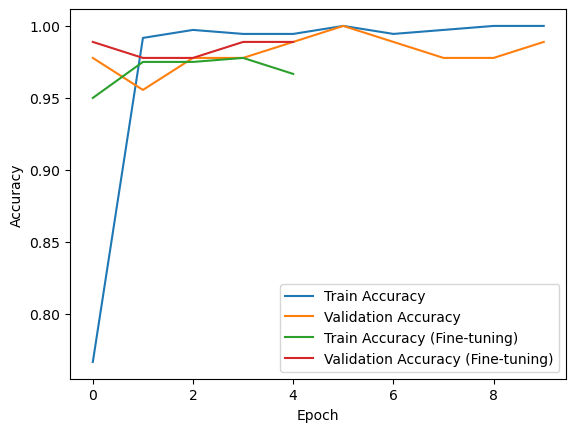

In [102]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Train Accuracy (Fine-tuning)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Loss Plot

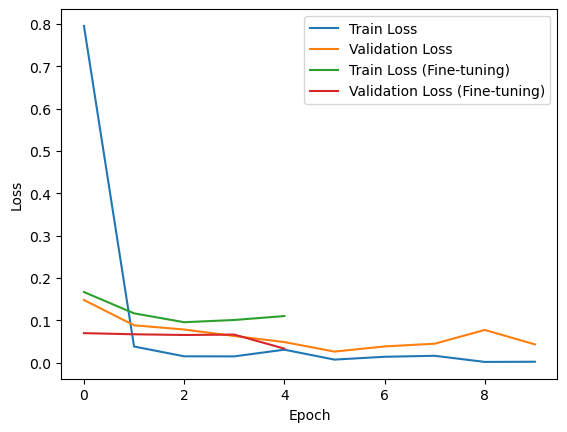

In [103]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Train Loss (Fine-tuning)')
plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
import pandas as pd
import numpy as np

# Fungsi untuk menghitung rata-rata metrics dari history dan mengembalikannya sebagai dataframe
def get_aggregated_results_df(history, phase_name):
    avg_train_acc = np.mean(history.history['accuracy']) * 100  # Akurasi dalam persen
    avg_train_loss = np.mean(history.history['loss']) * 100  # Loss dalam persen
    avg_val_acc = np.mean(history.history['val_accuracy']) * 100  # Akurasi validation dalam persen
    avg_val_loss = np.mean(history.history['val_loss']) * 100  # Loss validation dalam persen
    
    # Buat dataframe untuk menyimpan hasil
    results = pd.DataFrame({
        "Phase": [phase_name],
        "Avg Training Accuracy": [f"{avg_train_acc:.2f}%"],
        "Avg Training Loss": [f"{avg_train_loss:.2f}%"],
        "Avg Validation Accuracy": [f"{avg_val_acc:.2f}%"],
        "Avg Validation Loss": [f"{avg_val_loss:.2f}%"]
    })
    return results

# Contoh pemanggilan fungsi untuk initial training dan fine-tuning
initial_training_results = get_aggregated_results_df(history, "Initial Training")
fine_tuning_results = get_aggregated_results_df(history_fine, "Fine-Tuning")

# Gabungkan hasil ke dalam satu dataframe
final_results_df = pd.concat([initial_training_results, fine_tuning_results], ignore_index=True)

# Tampilkan DataFrame
final_results_df


,Phase,Avg Training Accuracy,Avg Training Loss,Avg Validation Accuracy,Avg Validation Loss
0,Initial Training,97.36%,9.37%,98.11%,6.57%
1,Fine-Tuning,96.89%,11.81%,98.44%,6.04%


- **Kesimpulan**  
  Pendekatan transfer learning dengan MobileNetV2 yang dilanjutkan dengan fine-tuning memberikan hasil yang memuaskan, terbukti dengan akurasi tinggi pada data validasi. Fine-tuning memungkinkan model beradaptasi lebih baik pada dataset gambar buah, meningkatkan generalisasi dan mengurangi risiko overfitting. Model ini sudah cukup baik untuk klasifikasi gambar buah, dan jika dataset diperluas di masa mendatang, fine-tuning dapat terus disesuaikan untuk meningkatkan performa.


## 6. Save the Model

In [ ]:
# model.save('model_buah.h5')


## 7. Predict Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


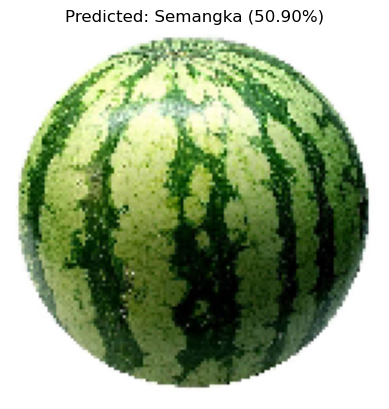

In [112]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('model_buah.h5')

# Correct path
img_path = r'D:\machinelearning fruit\test\semangka1.jpg'

# Load and preprocess an image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

class_labels = {
    0: 'Apel',
    1: 'Buah Naga',
    2: 'Durian',
    3: 'Jeruk',
    4: 'Mangga',
    5: 'Manggis',
    6: 'Nenas',
    7: 'Pisang',
    8: 'Semangka'
}

# Display the image and prediction
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title(f"Predicted: {class_labels[predicted_class]} ({predictions[0][predicted_class]*100:.2f}%)")
plt.show()


- **Memuat Model**  
  Kami memuat model yang telah dilatih sebelumnya dari file `model_buah.h5`, sehingga model dapat langsung digunakan tanpa perlu dilatih ulang.

- **Menyiapkan Gambar Test**  
  Setelah model dimuat, kami memuat path gambar test yang akan diprediksi.

- **Memproses Gambar**  
  Setelah gambar dimuat, gambar dikonversi menjadi array menggunakan `img_to_array` dan dinormalisasi dengan membagi nilai pikselnya dengan 255.0 agar berada dalam rentang [0, 1]. Kami menambahkan dimensi ekstra pada array dengan `np.expand_dims` agar sesuai dengan dimensi batch (128, 128).

- **Melakukan Prediksi**  
  Dengan gambar yang sudah diproses, kami menggunakan `model.predict(img_array)` untuk mendapatkan array probabilitas tiap kelas. Kami mengambil kelas dengan probabilitas tertinggi menggunakan `np.argmax(predictions)` untuk mendapatkan `predicted_class`.

- **Mendefinisikan Label Kelas**  
  Kami membuat dictionary `class_labels` untuk memetakan label numerik ke nama buah yang sesuai, sehingga hasil prediksi lebih mudah dipahami.

- **Menampilkan Hasil Prediksi**  
  Menggunakan `matplotlib`, kami menampilkan gambar input beserta hasil prediksinya. Kami menambahkan teks prediksi di atas gambar dengan `plt.title`, yang menampilkan nama buah dan tingkat confidence dari model.
